## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [83]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

# 1)

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
file_input = '/home/lorenzo/data/data_000637.txt'
data = pd.read_csv(file_input)
data.shape

(1310720, 6)

In [86]:
N = 100000
ndata = data[:N]
print(ndata.shape)
ndata.head()

(100000, 6)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


# 2)

In [87]:
x = data['BX_COUNTER'].max() + 1
print('x: ', x)

x:  3564


# 3)

In [88]:
def time_converter (data, n):
    x  = 3564
    t1 = data.loc[n, 'TDC_MEAS']*25/30
    t2 = data.loc[n, 'BX_COUNTER']*25
    t3 = data.loc[n, 'ORBIT_CNT']*x*25
    return t1+t2+t3
total_time = time_converter(data, len(data)-1) - time_converter(data, 0)
print('total time:', total_time, 'ns')

total time: 980416093.3125 ns


# 4)

In [89]:
data['ABS_TIME'] = data['TDC_MEAS']*25/30 + data['BX_COUNTER']*25 + data['ORBIT_CNT']*x*25
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14


# 5)

In [90]:
data['HEAD'] = np.random.randint(0,2,len(data))
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,0,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,0,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14


# 6)

In [91]:
data1 = data[data['HEAD'] == 1]
data1.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
1,1,0,124,3869200167,2374,27,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
9,1,0,60,3869200167,2788,7,3.447457e+14
11,1,0,64,3869200167,2786,19,3.447457e+14


# 7)

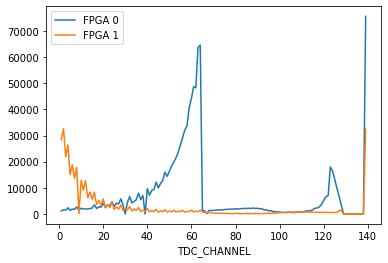

In [92]:
data_gr = data.groupby(['FPGA','TDC_CHANNEL']).count()
fpga0 = data_gr.loc[0]['HEAD']
fpga1 = data_gr.loc[1]['HEAD']
fpga0.plot(label='FPGA 0')
fpga1.plot(label='FPGA 1')
plt.legend()

 # 8)

In [93]:
data_gr2 = data.groupby(['TDC_CHANNEL']).count()
top_channel = data_gr2.sort_values(by='HEAD', ascending=False).index[0:3]
top_channel

Int64Index([139, 64, 63], dtype='int64', name='TDC_CHANNEL')

# 9)

In [94]:
data_gr3 = data.groupby(['ORBIT_CNT']).count()
unique_orbits = data_gr3[data_gr3['HEAD'] == 1].index
print('Unique orbits:', np.array(unique_orbits))

Unique orbits: [3869204142 3869206180]


In [95]:
data_gr4 = data.groupby(['TDC_CHANNEL', 'ORBIT_CNT']).count().loc[139, 'HEAD']
unique_orbits2 = data_gr4[data_gr4 == 1].index
print('Unique orbits of channel 139:', np.array(unique_orbits2))

Unique orbits of channel 139: [3869200471 3869200685 3869201150 3869201336 3869201354 3869201637
 3869201671 3869202062 3869202503 3869202570 3869202701 3869202919
 3869203149 3869203275 3869203303 3869203329 3869203371 3869203633
 3869203666 3869203746 3869203807 3869203811 3869203957 3869204020
 3869204060 3869204217 3869204275 3869204374 3869204428 3869204457
 3869204478 3869204503 3869204582 3869204762 3869204770 3869204799
 3869204860 3869205111 3869205161 3869205326 3869205573 3869205813
 3869206003 3869206197 3869206239 3869206248 3869206296 3869206321
 3869206362 3869206396 3869206419]
